# Домашнее задание 5

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 17 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_5

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию SGD:
$$
x^{k+1} = x^k - \gamma (\nabla f(x^k) + \xi^k),
$$
где $\xi^k$ - независимая от $x^k$ случайная величина из нормального распределения $\mathcal{N}(0, 100)$.

Для такого метода с $\gamma = \frac{1}{L}$ постройте график сходимости (критерий $\| \nabla f(x^k)\|^2$). Постройте на этом же графике сходимость честного градиентного спуска c $\gamma = \frac{1}{L}$. Сделайте вывод о характере сходимости нового метода.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import load_svmlight_file
import time 
np.random.seed(43) 

In [3]:
def generator(d, mu, L):
    D = np.diag(np.repeat([L, mu], [d / 2 + 1, d / 2 - 1]))
    Sample = (L - mu) * np.random.rand(d, d) + mu
    Q, _ = np.linalg.qr(Sample)
    A = Q.T @ D @ Q
    return A

In [4]:
d = 100
mu = 1
L = 1000
A = generator(d, mu, L)
b = 500 * np.random.randn(d) - 450

In [5]:
def f(x):
    return 1 / 2 * x.T @ A @ x - b.T @ x

In [6]:
def nabla_f(x):
    return A @ x - b

In [7]:
def GD(f, nabla_f, gamma, eps = 10**(-3)):
    error = []
    x_cur = np.random.randn(d)
    
    while(True):
        x_new = x_cur - gamma * nabla_f(x_cur)
        
        error.append(np.linalg.norm(nabla_f(x_cur))**2)
        
        if np.linalg.norm(nabla_f(x_cur))**2 < eps or len(error) > 10**5:
            break
        
        x_cur = x_new
    return x_new, error

In [8]:
def const_gamma(k):
    return 1 / L

In [9]:
def dyn_gamma(k):
    return 1 / (k + 2 * L)

In [16]:
def SGD(f, nabla_f, gamma = const_gamma, batch = False, eps = 10**(-3)):
    error = []
    x_cur = np.random.randn(d)
    num_iter = 0
    count_grads = [0]
    
    while(True):
        
        if batch == False:
            x_new = x_cur - gamma(num_iter) * (nabla_f(x_cur) + 10 * np.random.standard_normal(size = d))
            error.append(np.linalg.norm(nabla_f(x_cur))**2)
            if np.linalg.norm(nabla_f(x_cur))**2 < eps or num_iter > 10**5:
                break
            x_cur = x_new
            num_iter += 1
        else:
            x_new = x_cur - gamma(num_iter) * (nabla_f(x_cur) + 
                        1 / batch * np.sum(10 * np.random.standard_normal(size = (d, batch)), axis = 1))
            count_grads.append(count_grads[-1] + batch)
            error.append(np.linalg.norm(nabla_f(x_cur))**2)
            if np.linalg.norm(nabla_f(x_cur))**2 < eps or num_iter > 10**5:
                count_grads.pop()
                break
            x_cur = x_new
            num_iter += 1
    return count_grads, error

In [11]:
_, GD_err = GD(f, nabla_f, 1 / L)
_, SGD_err = SGD(f, nabla_f)

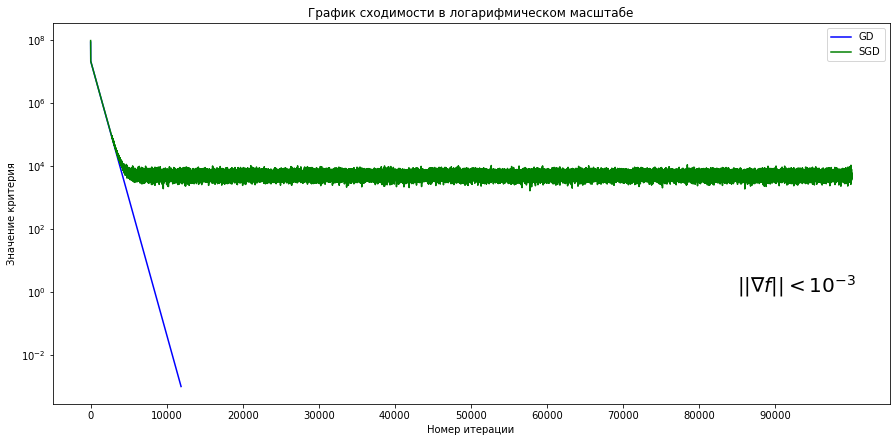

In [12]:
fig = plt.figure(figsize = (15, 7))
x1 = np.array(range(len(GD_err)))
x2 = np.array(range(len(SGD_err)))
plt.plot(x1, GD_err, color = 'blue', label = 'GD')
plt.plot(x2, SGD_err, color = 'green', label = 'SGD')
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Номер итерации")
plt.ylabel("Значение критерия")
plt.yscale("log")
plt.text(85000, 1, r'$||\nabla f|| < 10^{-3}$', fontsize = 20)
plt.xticks(range(0, 10**5, 10000))
plt.legend()
plt.show()

Как видно из графиков, с таким большим шумом SGD начинает сходиться, но около $10^4$ шум становится больше, чем информативные значения, поэтому дальше идет осцилляция около этого значения. Обычный градиентный спуск сходится без эксцессов.

__(б)__ На семинаре обсуждались способы борьбы со "стохастичностью" сходимости градиентного спуска. В частности, мы затронули использование уменьшающегося шага (смотри, например, Теорему 5 из [работы](https://arxiv.org/pdf/1907.04232.pdf)), а также использование батчирования (в нашем случае это просто замена: $\xi^k \to \frac{1}{b} \sum\limits_{i=1}^b \xi^k_i$, где $\xi^k_i \in \mathcal{N}(0, 100)$ и независимы). Реализуйте эти модификации (для батчирования возьмите $b = 10 , 100$). Добавьте полученные результаты на график сходимости из пункта (а). Постройте также график сходимости, где по оси $x$ будет не количество итераций, а количество генераций $\xi^k_i$ (количество вызовов стохастического градиента).

In [13]:
def const_gamma(k):
    if k < 9000: 
        return 1 / L
    else:
        return 1 / (2*L + k)

In [17]:
x3, SGD_err_b1 = SGD(f, nabla_f, batch = 10)
x4, SGD_err_b2 = SGD(f, nabla_f, batch = 100)
_, SGD_err_dyn = SGD(f, nabla_f, gamma = dyn_gamma)

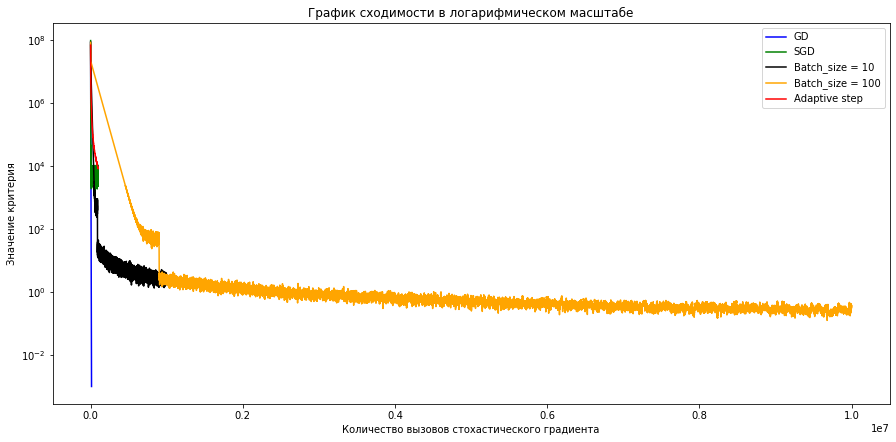

In [20]:
fig = plt.figure(figsize = (15, 7))
x5 = np.array(range(len(SGD_err_dyn)))
plt.plot(x1, GD_err, color = 'blue', label = 'GD')
plt.plot(x2, SGD_err, color = 'green', label = 'SGD')
plt.plot(x3, SGD_err_b1, color = 'black', label = 'Batch_size = 10')
plt.plot(x4, SGD_err_b2, color = 'orange', label = 'Batch_size = 100')
plt.plot(x5, SGD_err_dyn, color = 'red', label = 'Adaptive step')
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Количество вызовов стохастического градиента")
plt.ylabel("Значение критерия")
plt.yscale("log")
#plt.xticks(range(0, 10**5 + 1, 10000))
plt.legend()
plt.show()

Видно, что количество вызовов стохастического градиента наибольшее при размере батча 100. Хотя это было ясно и без построения графиков.

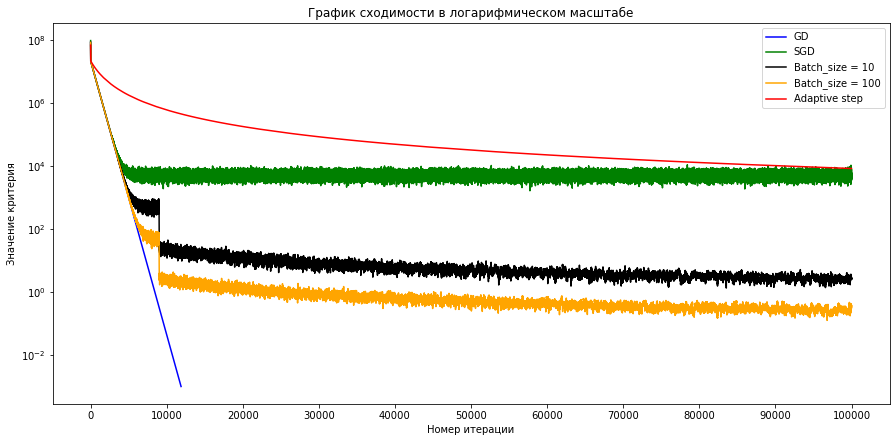

In [21]:
fig = plt.figure(figsize = (15, 7))
x5 = np.array(range(len(SGD_err_dyn)))
x4 = np.array(range(len(SGD_err_b2)))
x3 = np.array(range(len(SGD_err_b1)))
plt.plot(x1, GD_err, color = 'blue', label = 'GD')
plt.plot(x2, SGD_err, color = 'green', label = 'SGD')
plt.plot(x3, SGD_err_b1, color = 'black', label = 'Batch_size = 10')
plt.plot(x4, SGD_err_b2, color = 'orange', label = 'Batch_size = 100')
plt.plot(x5, SGD_err_dyn, color = 'red', label = 'Adaptive step')
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Номер итерации")
plt.ylabel("Значение критерия")
plt.yscale("log")
plt.xticks(range(0, 10**5 + 1, 10000))
plt.legend()
plt.show()

Как видно из графиков, батчирование изменяет характер сходимости, мы получаем большую точность, однако снова в какой-то момент шум становится значительнее информации. Адаптивный подбор шага работает долго.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). Как мы знаем, эта задача имеет вид конечной суммы:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{n} \sum\limits_{j=1}^n f_j(w) := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b f_{ji}(w)\right] := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_i), y_i)\right],
\end{equation}
где $nb = N$ - полный размер выборки. Решите данную задачу с помощью SGD, SAGA (секция А.5 из [работы](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (секция А.9 из [работы](https://arxiv.org/pdf/1905.11261.pdf)) и SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. Обратите внимание, что теория для SAGA, SVRG, SARAH предполагает, что $L$ - это константа Липшица градиентов $\nabla f_j$. 

Аналогично третьему дз считаем гессиан функции эмпирического риска, только теперь он на батче: 
$$ 
\nabla^2 f_j(w) = \dfrac{1}{b} \sum\limits_{i=1}^b \dfrac{\exp(-y_{(j-1)b + i} w^Tx^{(j-1)b + i})}{(1 + \exp(-y_{(j-1)b + i} w^Tx^{(j-1)b + i}))^2} \cdot x^{(j-1)b + i}(x^{(j-1)b + i})^T
$$
Концептуально ничего не изменилось, поэтому также получаем: 
$$
\nabla^2 f_j(w) \preccurlyeq \dfrac{1}{4} \lambda_{\max}\left(x^i (x^i)^T\right)
$$
Тогда имеем: 
$$
L_j = \dfrac{1}{4(b - 1)} \lambda_{\max} \left(x^i (x^i)^T\right), ~~i \in \overline{(j-1)b+1, jb}
$$
Константу сильной выпуклости, точно как в дз 3, можно оценить только нулем, тк $\underset{x \in \mathbb{R}}{\inf}\dfrac{e^x}{(1 + e^x)^2} = 0$.

__(б)__ Реализуйте SGD, SAGA, SVRG, SARAH для задачи логистической регресии из $n$ слагаемых, где каждое слагаемое так же имеет виды суммы размеры $b$. Каким надо взять $b$? Почему? Что об этом говорит теория? Как будете выбирать шаг и другие параметры методов?

В статье https://arxiv.org/pdf/1206.5533.pdf говорится, что хорошим выбором размера батча для абстрактной задачи является batch_size = 32. В принципе я не нашел каких-либо строгих доказательств того, почему нам подходит именно такой размер(помимо того, что степень двойки позволяет лучше использовать возможности GPU), например в этой статье(https://arxiv.org/pdf/1804.07612.pdf) показывается, что batch_size = 8 при правильном выборе learning rate показывает лучшие результаты для AlexNet, а для ResNet на том же датасете лучше брать batch_size = 4. Однако всегда(когда обучаться не долго) можно попровать запутиться несколько раз на разных размерах и посмотреть, что лучше. Шаг во всех алгоритмах выбран константный в соответствии с тем, как написано в работах. Количество итераций методов на батче подобрал эмпирически, используя следующую логику: нам не нужно иметь слишком большую тоность на батче, тк тогда алгоритм будет работать очень долго и есть риск переобучиться, достаточно сделать небольшое(10 - 100) число итераций, тогда получится неплохая точность и небольшое время.

In [23]:
def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [40]:
class Logistic:
    def __init__(self):
        self.w = None
        
    def fit(self, X, y, gamma, method = 'GD', reg = False, batch_size_global = 10, eps = 10**(-3), batch_size_local = 10):
        self._reg = reg
        #Время
        self.times = [0]
        time_now = 0
        #Инициализируем входные данные
        n, k = X.shape
        self.w = np.random.randn(k)
        self.errors = [np.linalg.norm(self._grad_function(X, y), ord = 2)]
        optimizer = self._choose_method(method)
        #Оцениваем L
        summ = 0
        for i in range(len(X)):
            summ += X[i][np.newaxis]  @ X[i][np.newaxis].T
        L = batch_size_global / (X.shape[0]) * np.max(np.linalg.eigvals(summ))
        #Learning rate
        if gamma == const_gamma:
            gamma = lambda x: 1 / (2 * L + x)
        #Регуляризация
        if self._reg == True:
            self._reg = L / 1000
        #Обучение
        while self.errors[-1] > eps:
            gen = self._generate_batches(X, y, batch_size_global)
            for X_batch, y_batch in gen:
                start_time = time.time()
                
                self.w = optimizer(self._function, self._grad_function, gamma, X_batch, y_batch, eps, batch_size_local)
                self.errors.append(np.linalg.norm(self._grad_function(X, y), ord = 2))
                
                end_time = time.time()
                time_now += end_time - start_time
                self.times.append(time_now)

            if len(self.errors) > 10**4:
                break
        print(self.errors[-1])
        return self
    
    def _GD(self, f, nabla_f, gamma, X, y, eps, trash):
        x_cur = self.w
        num_iter = 0
        while(np.linalg.norm(nabla_f(X, y), ord = 2) > eps * 100):
            self.w = x_cur - gamma(num_iter) * nabla_f(X, y)
            x_cur = self.w
            num_iter += 1
            if num_iter > 10: return self.w
        return self.w
    
    def _SGD(self, f, nabla_f, gamma, X, y, eps, trash):
        num_iter = 0
        while(np.linalg.norm(nabla_f(X, y), ord = 2) > eps * 100):
            noise = np.concatenate((np.random.normal(0, 10, X.shape[0]), np.zeros(self.w.shape[0] - X.shape[0])))
            np.random.shuffle(noise)
            
            self.w -= gamma(num_iter) * (nabla_f(X, y) + 0.05 * noise)
            
            num_iter += 1
            if num_iter > 10: return self.w
        return self.w
    
    def _SGDb(self, f, nabla_f, gamma, X, y, eps, batch_size):
        num_iter = 0
        while(np.linalg.norm(nabla_f(X, y), ord = 2) > eps * 100):
            noise = 0.01 * np.concatenate((1 / batch_size * np.sum(np.random.normal(0, 10, (X.shape[0], batch_size)), axis = 1),
                                    np.zeros(self.w.shape[0] - X.shape[0])))
            np.random.shuffle(noise)
            self.w -= gamma(num_iter) * (nabla_f(X, y) + noise)
            num_iter += 1
            if num_iter > 10: return self.w  
        return self.w
    
    def _SVRG(self, f, nabla_f, gamma, X, y, eps, batch_size):
        phi = self.w
        for s in range(10):
            history = []
            for k in range(batch_size):
                i = np.random.randint(low = 1, high = X.shape[1])
                crutch1 = self._grad_function_x(X, y, phi)
                crutch2 = self._grad_function(X, y)
                estimator = crutch2[i] - crutch1[i] + crutch1
                
                self.w -= gamma(0) * estimator
                
                history.append(self.w)
                
            phi = 1 / batch_size * sum(history)   
        return self.w
    
    def _SARAH(self, f, nabla_f, gamma, X, y, eps, batch_size):
        w_wave = [self.w]
        for i in range(5):
            w = [w_wave[i - 1]]
            v = self._grad_function_x(X, y, w[0])
            w.append(w[0] - gamma(0) * v)
            for t in range(1, batch_size):
                i = np.random.randint(X.shape[0] // batch_size + 1)
                v += self._grad_function_x(X, y, w[-1]) - self._grad_function_x(X, y, w[-2])
                w.append(w[-1] - gamma(0) * v)
            w_wave.append(w[np.random.randint(X.shape[0] // batch_size + 1)])
        self.w = w[-1]
        return self.w
    
    def _SAGA(self, f, nabla_f, gamma, X, y, eps, batch_size):
        psi = np.array([self.w for i in range(X.shape[1])])
        for k in range(1, 101):
            j = np.random.randint(low = 0, high = X.shape[1])
            crutch = self._grad_function_x(X, y, psi[j])[j]
            psi[j] = self.w
            estimator = self._grad_function(X, y) + self._grad_function_x(X, y, psi[j])[j] - crutch
            self.w -= gamma(0) * estimator
        return self.w
    
    def _choose_method(self, method):
        if method == 'GD':
            return self._GD
        if method == 'SGD':
            return self._SGD
        if method == 'SGDb':
            return self._SGDb
        if method == 'SAGA':
            return self._SAGA
        if method == 'SVRG':
            return self._SVRG
        if method =='SARAH':
            return self._SARAH
    
    def _function(self, X, y):
        ans = 0
        n = X.shape[0]

        for i in range(len(y)):     
            ans = ans + 1/n * np.log(1 - np.exp(-y[i] * X[i] @ self.w)) 
        return ans

    def _grad_function(self, X, y):    
        z = sigmoid(X @ self.w)
        ans = np.dot(X.T, (z - y)) / len(y) 
        if self._reg == True:
            return ans + 2 * self._reg * self.w
        return ans
    
    def _grad_function_x(self, X, y, x):    
        z = sigmoid(X @ x)
        ans = np.dot(X.T, (z - y)) / len(y) 
        if self._reg == True:
            return ans + 2 * self._reg * x
        return ans
    
    def predict(self, X, treshhold = 0.5):
        y_pred = self.predict_proba(X)
        y_pred[y_pred >= treshhold] = 1
        y_pred[y_pred < treshhold] = 0

        return y_pred
    
    def predict_proba(self, X):
        return 1/(1 + np.exp(- X @ self.w))
    
    def _generate_batches(self, X, y, batch_size):
        X = np.array(X)
        y = np.array(y)
        perm = np.random.permutation(len(X))
        perm = perm[:((len(X) // batch_size) * batch_size)]
        X_batch = []
        y_batch = []

        for batch_start in np.hsplit(perm, len(X) // batch_size): 
            for i in range(len(batch_start)):
                X_batch.append(X[batch_start[i], :])
                y_batch.append(y[batch_start[i]])
            yield np.array(X_batch), np.array(y_batch)
            X_batch = []
            y_batch = []
        
    def get_times(self):
        return self.times
    
    def get_errors(self):
        return self.errors

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество подсчетов $\nabla f_{ji}$, по оси $y$ - $\|\nabla f(w^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [24]:
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

In [25]:
y = pd.DataFrame(y)
y = np.array(y.replace(2, 0)).reshape(8124,)

In [38]:
optimizers = ['SVRG', 'SARAH', 'SAGA', 'SGD']

0.007516888870035917
0.012244519719598694
0.007839386009632323
0.15641653012851897


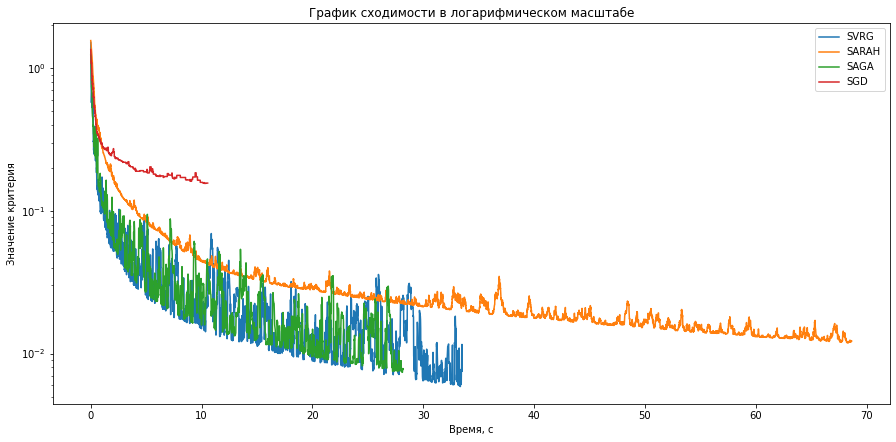

In [41]:
fig = plt.figure(figsize = (15, 7))

for i in optimizers:
    model = Logistic()
    model.fit(X, y, gamma = const_gamma, method = i, eps = 10**(-2), reg = 0.01)
    error = model.get_errors()
    x = model.get_times()
    plt.plot(x, error, label = i)

plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Время, с")
plt.ylabel("Значение критерия")
plt.yscale("log")
plt.legend()
plt.show()

0.0018205902823849119
0.010173453285524083
0.0016514121655607345
0.019463919073568082


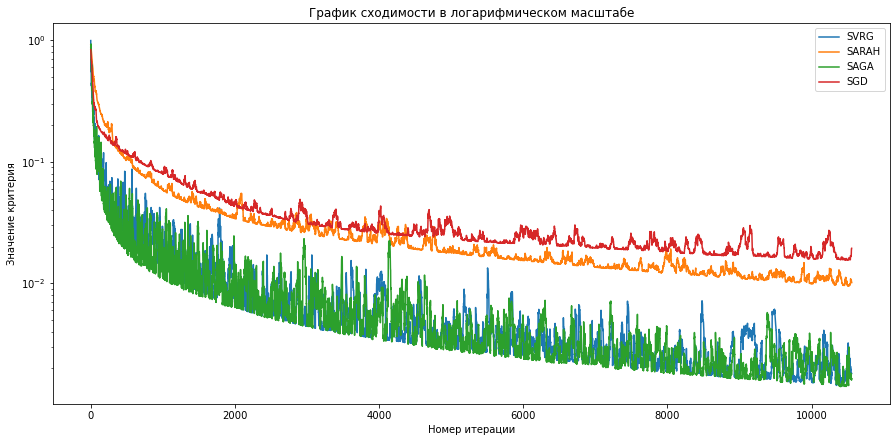

In [42]:
fig = plt.figure(figsize = (15, 7))

for i in optimizers:
    model = Logistic()
    model.fit(X, y, gamma = const_gamma, method = i, reg = 0.01)
    error = model.get_errors()
    x = np.array(range(len(error)))
    plt.plot(x, error, label = i)

plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Номер итерации")
plt.ylabel("Значение критерия")
plt.yscale("log")
plt.legend()
plt.show()

Если смотреть по огибающим графиков сходимости, то получается, что лучше всего сходится SAGA, далее SVRG, он сходится почти так же, потом идет SARAH и хуже всех обычный градиентный спуск. Однако ясно, например, что градиентный спуск использует меньше всех памяти и вызовов стохастического градиента. Больше всех памяти тратит SAGA, а самый большой разброс ошибки у SVRG.

__Бонусные пункты__

__(г)__ Методы SGD, SAGA, SVRG, SARAH, которые мы рассматривали, предполагают случайный выбор индекса на каждой итерации. Но между тем, на практике обычно делают по-другому и просто последовательно меняют $i_k$ от $1$ до $n$ (а потом заново). В [работе](https://arxiv.org/abs/2006.05988) изучаются такие подходы. Реализуйте Random Reshuffling и Shuffle Once для SGD и SARAH. Сравните новые алгоритмы со старыми версиями SGD и SARAH из пунктов (б) и (в).

In [ ]:
#ответ

__(д)__ Методы SVRG и SARAH имеют loopless версии: L-SVRG (секция А.10 из [работы](https://arxiv.org/pdf/1905.11261.pdf) и PAGE ([работа](https://proceedings.mlr.press/v139/li21a.html)), соотвественно. Реализуйте их. Как будете выбирать вероятности в этих алгоритмах? Сравните новые алгоритмы со старыми версиями SVRG и SARAH из пунктов (б) и (в).

In [ ]:
#ответ